In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

#keyword = "Meep"
keyword = "NormalNewGeom"
path = "../../../json/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

#omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
#bumps = params["bumpData"]
bumps = []

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]
# fcen = params["freqCenter"]
# df = params["freqWidth"]
# nfrq = params["freqs_n"]

lambda_min = params["minLambda"]
lambda_max = params["maxLambda"]
lambda_n = params["lambda_n"]

fmin = 1.0 / lambda_max
fmax = 1.0 / lambda_min

fcen = (fmin + fmax) / 2.0
df = (fmax - fmin)
nfrq = lambda_n

pml_layers = [mp.PML(thickness=pml_thickness)] 

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size[0], cell_size[1], 0),
        component=component
    )]


def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box1_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box1_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    sim.run(until_after_sources=60)

    box_x1 = mp.get_fluxes(box1_x1)
    box_x2 = mp.get_fluxes(box1_x2)
    box_y1 = mp.get_fluxes(box1_y1)
    box_y2 = mp.get_fluxes(box1_y2)
    box_z1 = mp.get_fluxes(box1_z1)
    box_z2 = mp.get_fluxes(box1_z2)

    # Save individual components for later printing/plotting
    inc_flux_components = {
        "X1": np.asarray(box_x1),
        "X2": np.asarray(box_x2),
        "Y1": np.asarray(box_y1),
        "Y2": np.asarray(box_y2),
        "Z1": np.asarray(box_z1),
        "Z2": np.asarray(box_z2),
    }

    box_x1_data = sim.get_flux_data(box1_x1)
    box_x2_data = sim.get_flux_data(box1_x2)
    box_y1_data = sim.get_flux_data(box1_y1)
    box_y2_data = sim.get_flux_data(box1_y2)
    box_z1_data = sim.get_flux_data(box1_z1)
    box_z2_data = sim.get_flux_data(box1_z2)

    sim.reset_meep()

# Structured simulation (with bumps) and edges
    def material_function(p):
        if abs(p.x) >= 1 or abs(p.y) >= 1:
            return mp.air
        z_surface = 0
        for b in bumps:
            dx = p.x - b["x0"]
            dy = p.y - b["y0"]
            exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
            z_surface += b["height"] * math.exp(exponent)
        return substrate if p.z + 1.5 < z_surface else mp.air



    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box2_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box2_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.load_minus_flux_data(box2_x1, box_x1_data)
    sim.load_minus_flux_data(box2_x2, box_x2_data)
    sim.load_minus_flux_data(box2_y1, box_y1_data)
    sim.load_minus_flux_data(box2_y2, box_y2_data)
    sim.load_minus_flux_data(box2_z1, box_z1_data)
    sim.load_minus_flux_data(box2_z2, box_z2_data)

    sim.run(until_after_sources=60) # maybe 20 is too little? 

    box_x1_flux = mp.get_fluxes(box2_x1)
    box_x2_flux = mp.get_fluxes(box2_x2)
    box_y1_flux = mp.get_fluxes(box2_y1)
    box_y2_flux = mp.get_fluxes(box2_y2)
    box_z1_flux = mp.get_fluxes(box2_z1)
    box_z2_flux = mp.get_fluxes(box2_z2)

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux),
        "X2": np.asarray(box_x2_flux),
        "Y1": np.asarray(box_y1_flux),
        "Y2": np.asarray(box_y2_flux),
        "Z1": np.asarray(box_z1_flux),
        "Z2": np.asarray(box_z2_flux),
    }


    freqs = mp.get_flux_freqs(box1_x1)  # or any box that was added with add_flux
    return scatt_flux_components, inc_flux_components, freqs


flux_results = []
inc_flux_results = []

def print_parameters():
    print("Simulation Parameters:")
    print(f"  resolution      = {resolution}")
    print(f"  cell_size       = ({cell_size.x}, {cell_size.y}, {cell_size.z})")
    print(f"  PML thickness   = {pml_thickness}")
    print(f"  monitor size    = {monitor_size}")
    print(f"  substrate ε     = {epsilon1}")
    print(f"  number of bumps = {len(bumps)}")
    print(f"  freq center     = {fcen:.4f} (→ λ ≈ {100 / fcen:.1f} nm)")
    print(f"  freq width      = {df:.4f} (from {fcen - df/2:.4f} to {fcen + df/2:.4f})")
    print(f"  freqs_n         = {nfrq} points")
    print("  betas (deg)     =", [round(np.degrees(b), 2) for b in betas])
    print()
print_parameters()


for beta in betas:
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_1 = make_source(mp.Ey)
    sources_2 = make_source(mp.Ex)
    
    flux_1, inc_flux_1, freqs = run_meep_simulation(sources_1)
    flux_2, inc_flux_2, freqs = run_meep_simulation(sources_2)

    for direction in ["X1", "X2", "Y1", "Y2", "Z1", "Z2"]:
        flux_arr = cos2 * flux_1[direction] + sin2 * flux_2[direction]
        inc_flux_arr = cos2 * inc_flux_1[direction] + sin2 * inc_flux_2[direction]

        for f, scatt_val, inc_val in zip(freqs, flux_arr, inc_flux_arr):
            flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": scatt_val,
                "type": "scattered"
            })
            inc_flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": inc_val,
                "type": "incident"
            })




Simulation Parameters:
  resolution      = 10
  cell_size       = (7.0, 7.0, 8.0)
  PML thickness   = 2
  monitor size    = 1
  substrate ε     = 2.56
  number of bumps = 0
  freq center     = 2.5000 (→ λ ≈ 40.0 nm)
  freq width      = 1.6667 (from 1.6667 to 3.3333)
  freqs_n         = 7 points
  betas (deg)     = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0]

beta = 0.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.00497913 s
Working in 3D dimensions.
Computational cell is 7 x 7 x 8 with resolution 10
time for set_epsilon = 0.762863 s
-----------
Meep progress: 7.25/66.0 = 11.0% done in 4.0s, 32.5s to go
on time step 145 (time=7.25), 0.0276137 s/step
Meep progress: 16.2/66.0 = 24.5% done in 8.0s, 24.6s to go
on time step 324 (time=16.2), 0.0223837 s/step
Meep progress: 24.05/66.0 = 36.4% done in 12.0s, 21.0s to go
on time step 481 (time=24.05), 0.0255702 s/step
Meep progress: 32.6/66.0 = 49.4% done in 16.1s, 16.4s to go
on time step 652 (time=32.6), 0.0235306 s/s

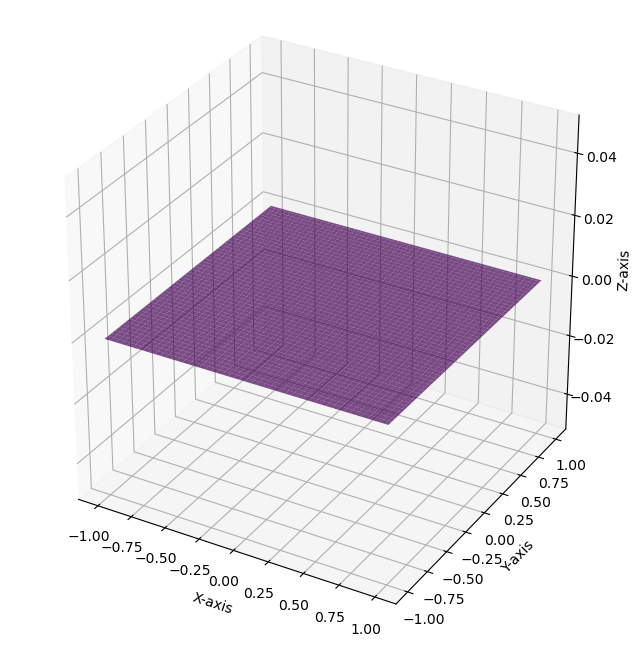

In [10]:
def plot_bump_surface():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1

    # Create a grid of points
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the Z values based on the bumps
    Z = np.zeros_like(X)
    for b in bumps:
        dx = X - b["x0"]
        dy = Y - b["y0"]
        exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
        Z += b["height"] * np.exp(exponent)

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()
plot_bump_surface()


In [11]:
import pandas as pd

df_scatt = pd.DataFrame(flux_results)
df_inc = pd.DataFrame(inc_flux_results)

# Save both to CSV
df_scatt.to_csv("../filesCSV/scattered_flux_results.csv", index=False)
df_inc.to_csv("../filesCSV/incident_flux_results.csv", index=False)

# Confirm structure
print(df_scatt.head())


   frequency  beta direction          flux       type
0   1.666667   0.0        X1  3.492432e-09  scattered
1   1.944444   0.0        X1  1.096976e-06  scattered
2   2.222222   0.0        X1  7.232717e-05  scattered
3   2.500000   0.0        X1 -1.024390e-05  scattered
4   2.777778   0.0        X1  3.702087e-05  scattered


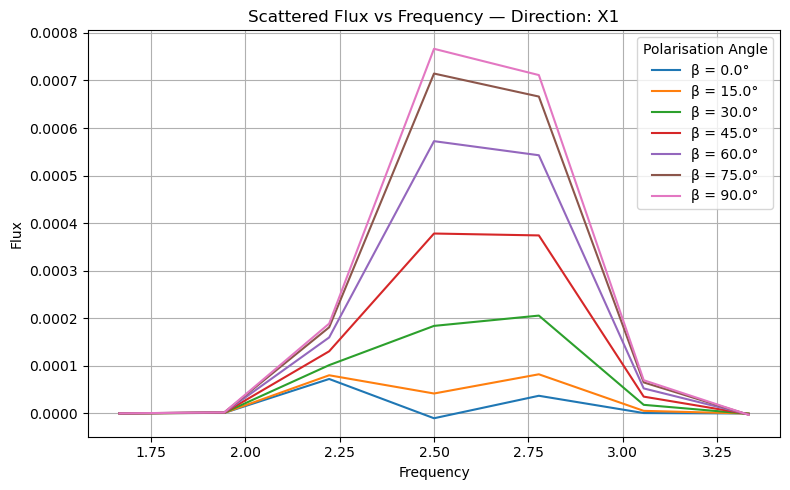

<Figure size 640x480 with 0 Axes>

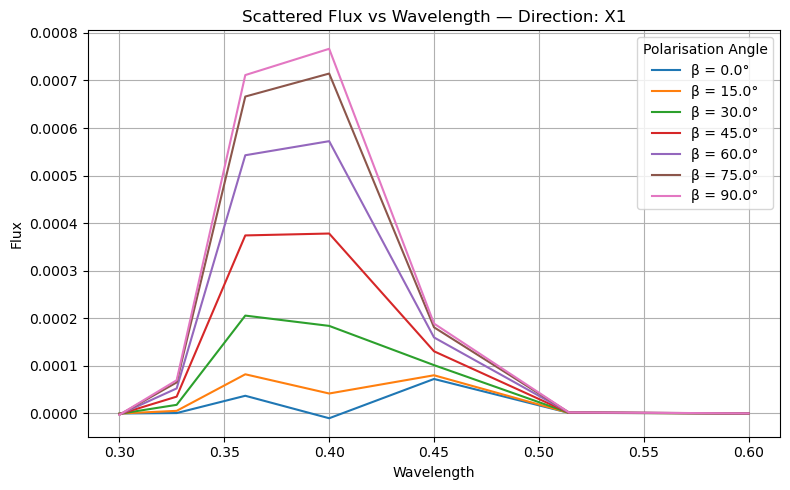

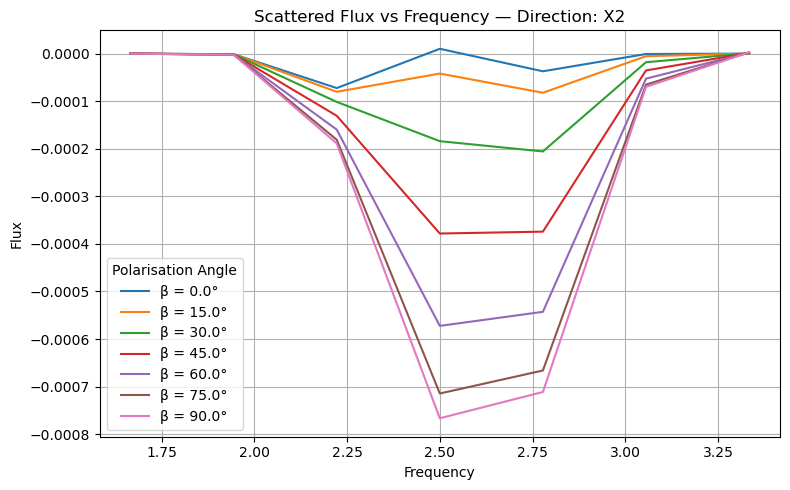

<Figure size 640x480 with 0 Axes>

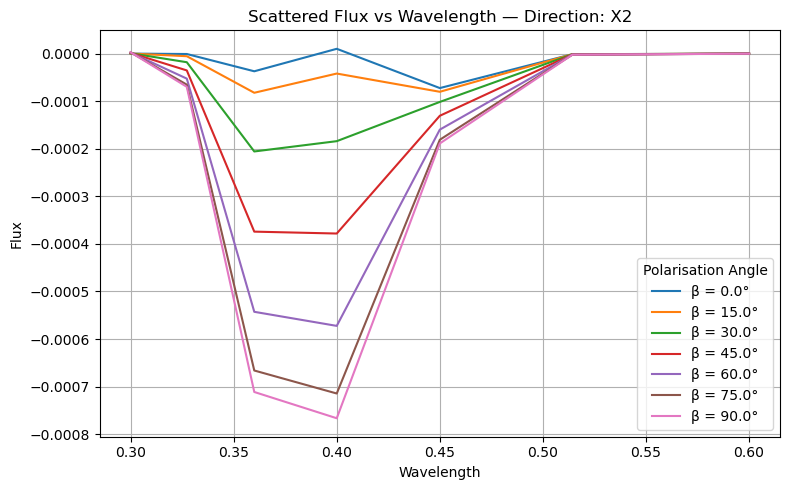

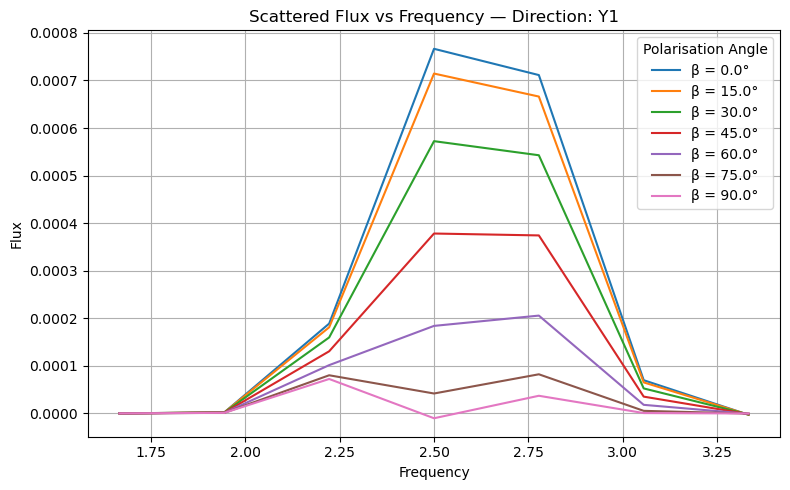

<Figure size 640x480 with 0 Axes>

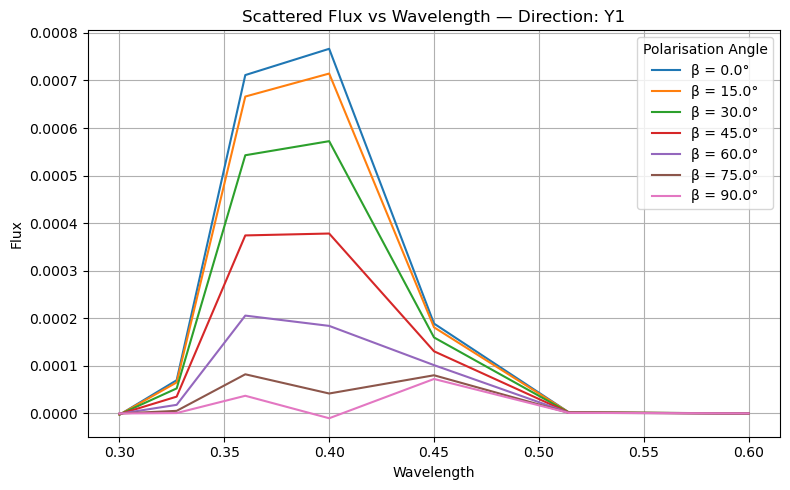

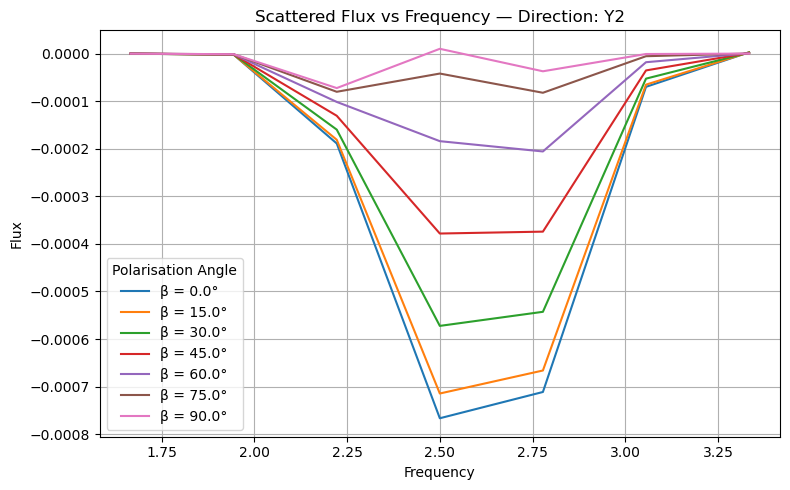

<Figure size 640x480 with 0 Axes>

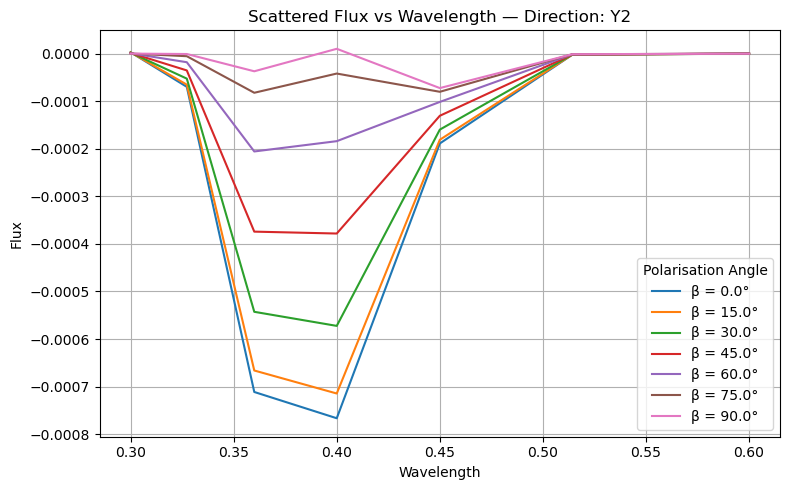

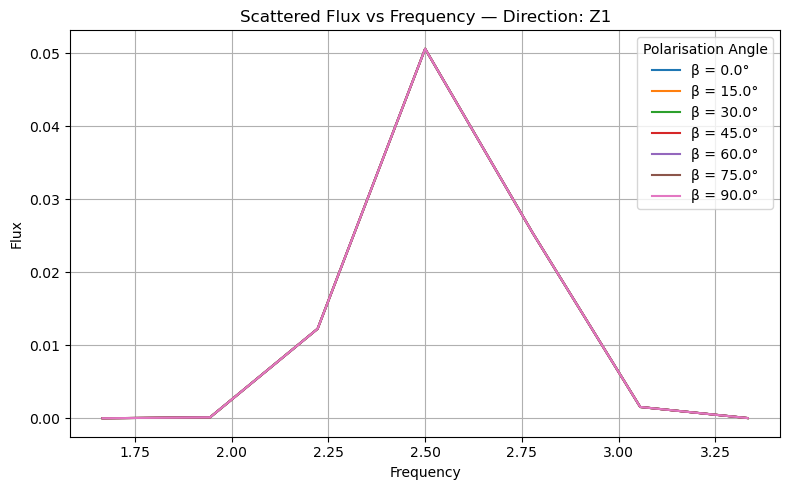

<Figure size 640x480 with 0 Axes>

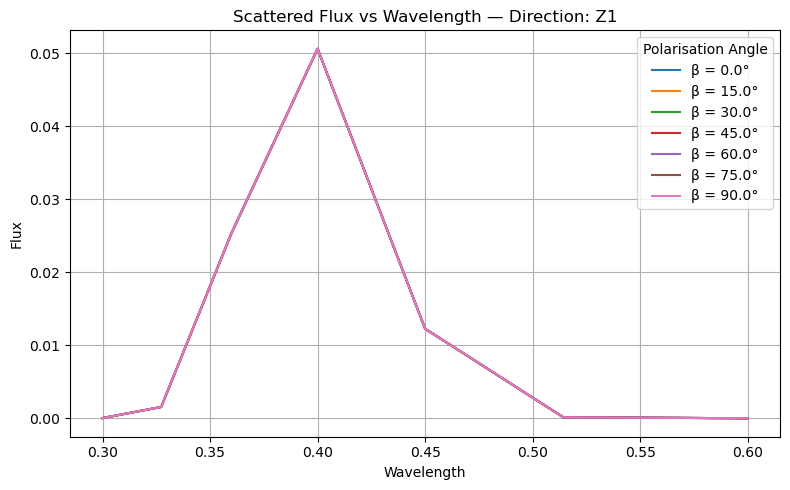

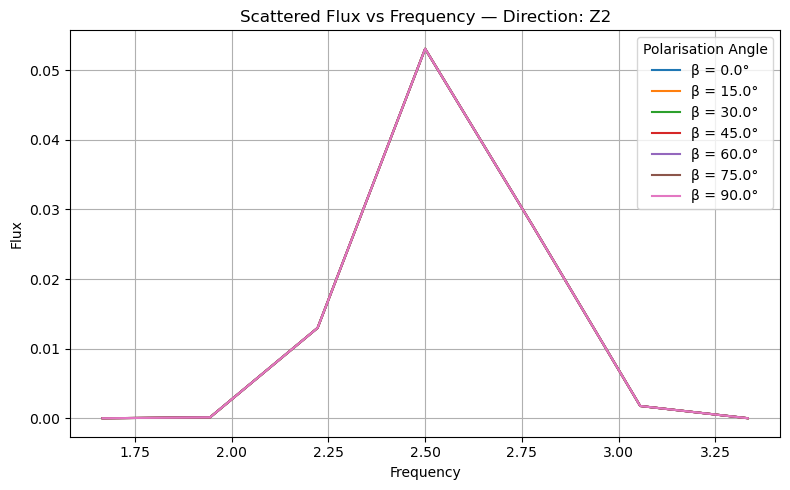

<Figure size 640x480 with 0 Axes>

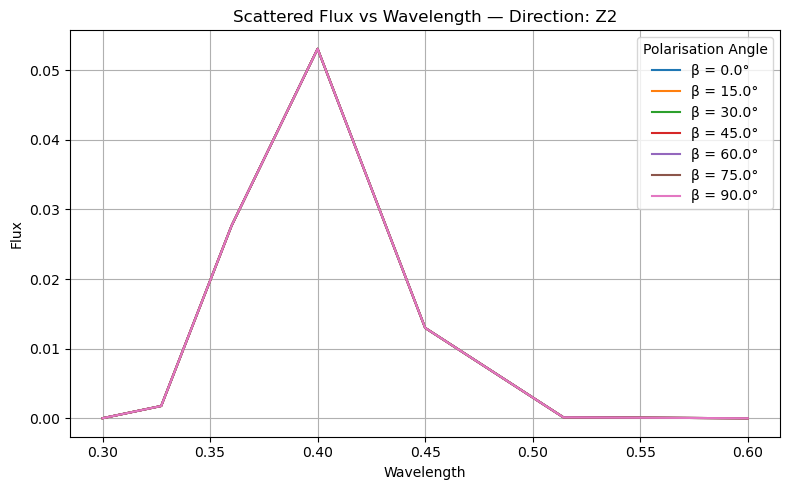

In [12]:
import matplotlib.pyplot as plt

directions = sorted(df_scatt["direction"].unique())
betas = sorted(df_scatt["beta"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for beta in betas:
        sub = df_scatt[(df_scatt["direction"] == direction) & (df_scatt["beta"] == beta)]
        plt.plot(sub["frequency"], sub["flux"], label=f"β = {beta:.1f}°")

    plt.title(f"Scattered Flux vs Frequency — Direction: {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Polarisation Angle")
    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig(f"../plots/scattered_flux_{direction}.png")

    # Plot flux vs wavelength
    plt.figure(figsize=(8, 5))
    for beta in betas:
        sub = df_scatt[(df_scatt["direction"] == direction) & (df_scatt["beta"] == beta)]
        wavelengths = 1 / sub["frequency"]
        plt.plot(wavelengths, sub["flux"], label=f"β = {beta:.1f}°")
    plt.title(f"Scattered Flux vs Wavelength — Direction: {direction}")
    plt.xlabel("Wavelength")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Polarisation Angle")
    plt.tight_layout()
    plt.savefig(f"../plots/scattered_flux_wavelength_{direction}.png")
    plt.show()
    plt.close()
    


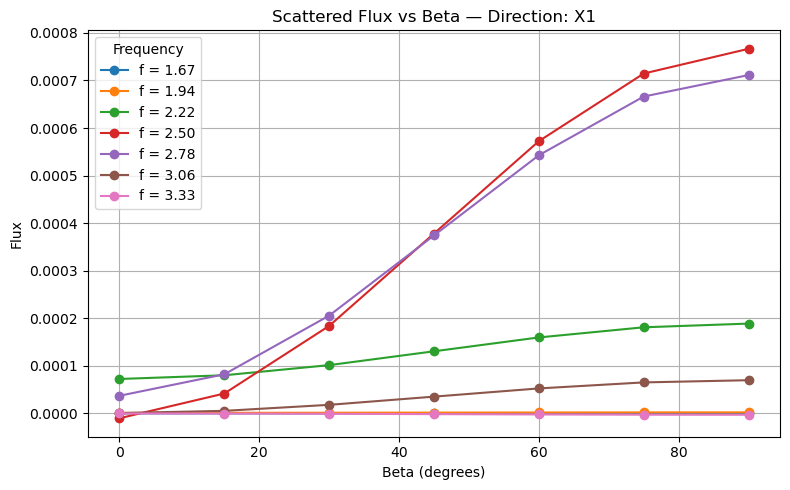

<Figure size 640x480 with 0 Axes>

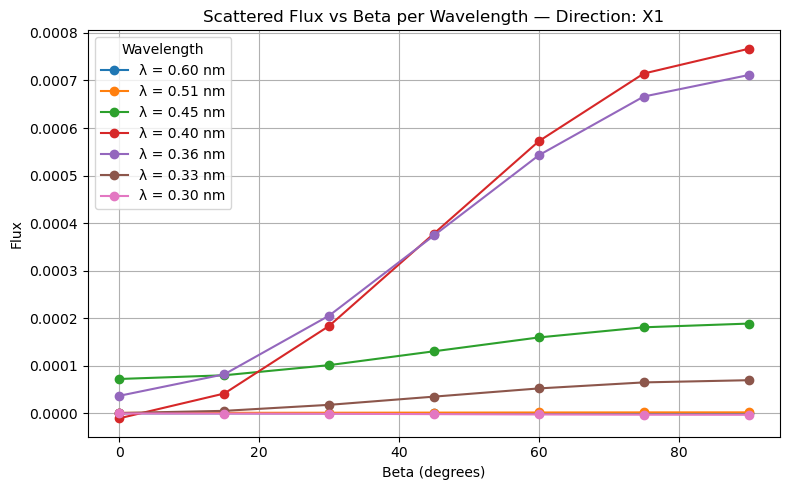

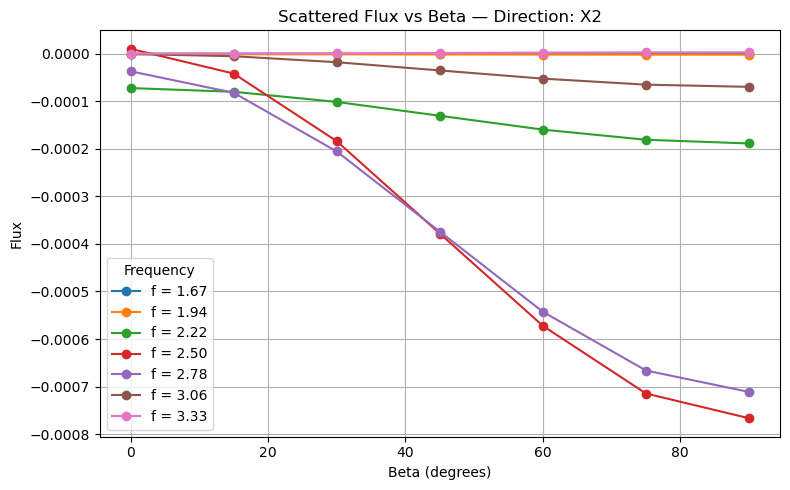

<Figure size 640x480 with 0 Axes>

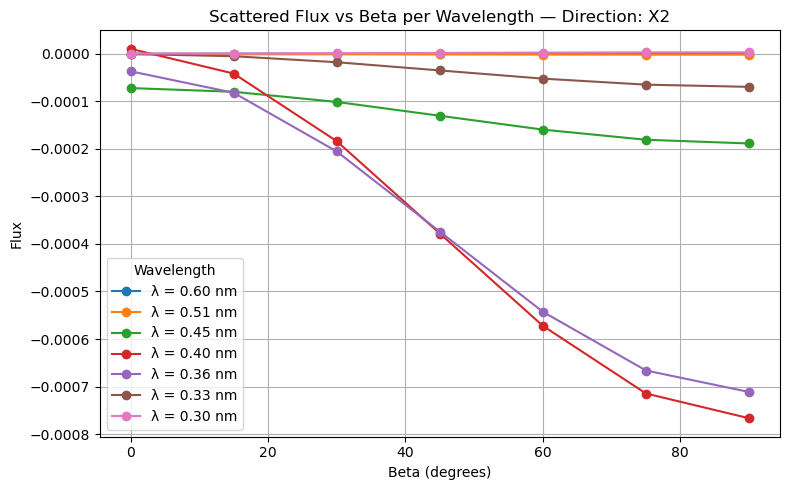

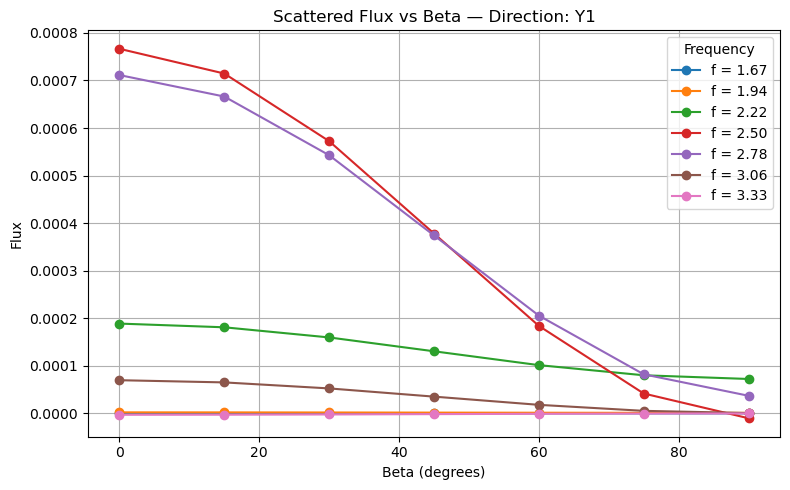

<Figure size 640x480 with 0 Axes>

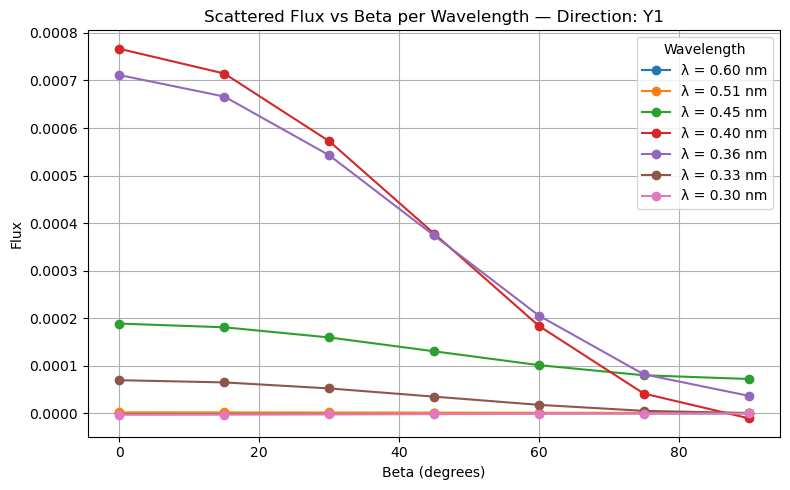

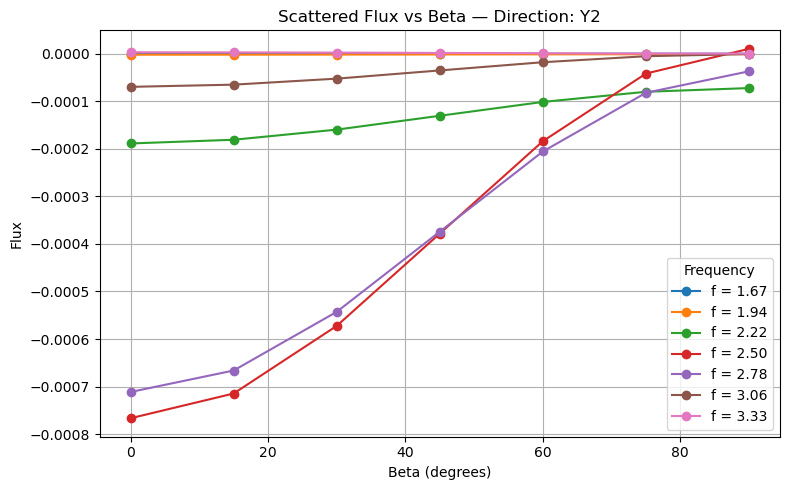

<Figure size 640x480 with 0 Axes>

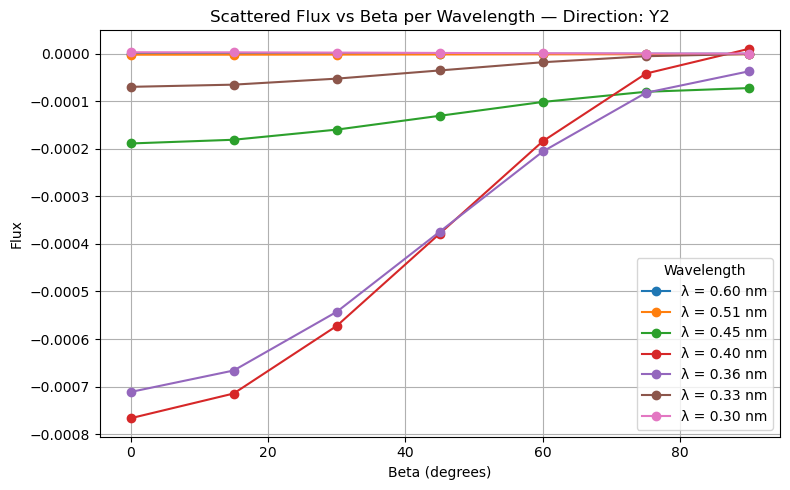

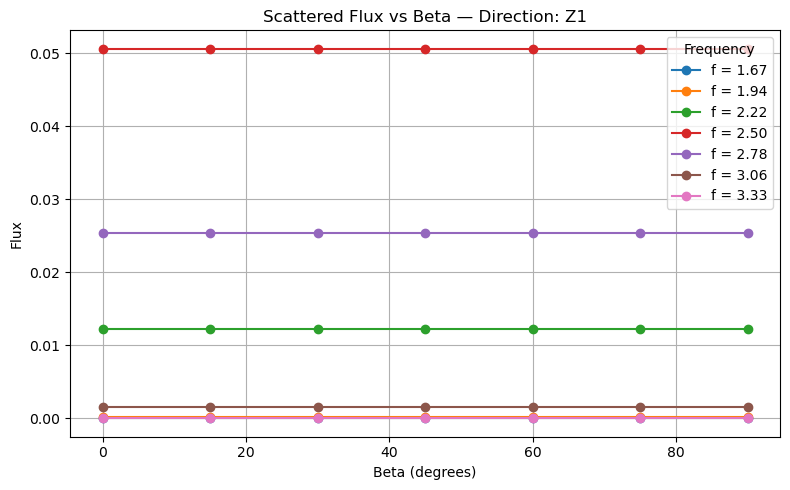

<Figure size 640x480 with 0 Axes>

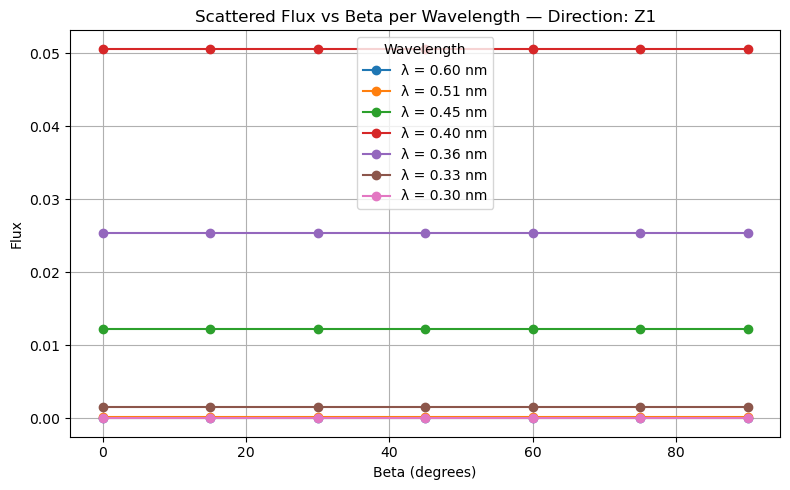

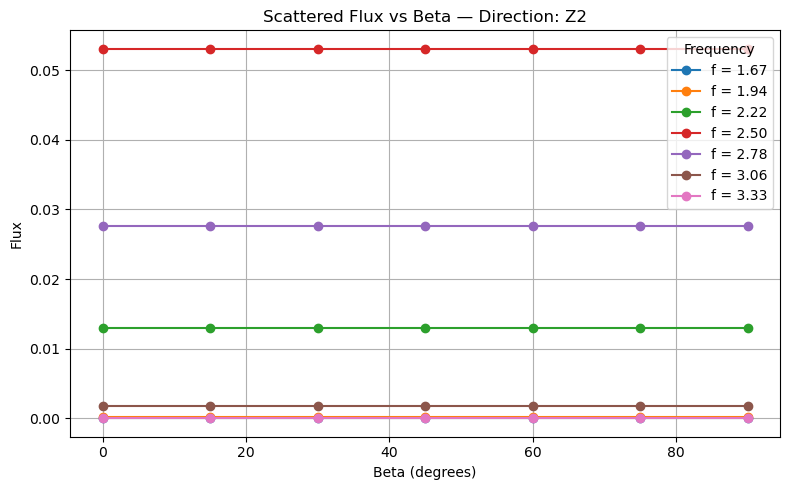

<Figure size 640x480 with 0 Axes>

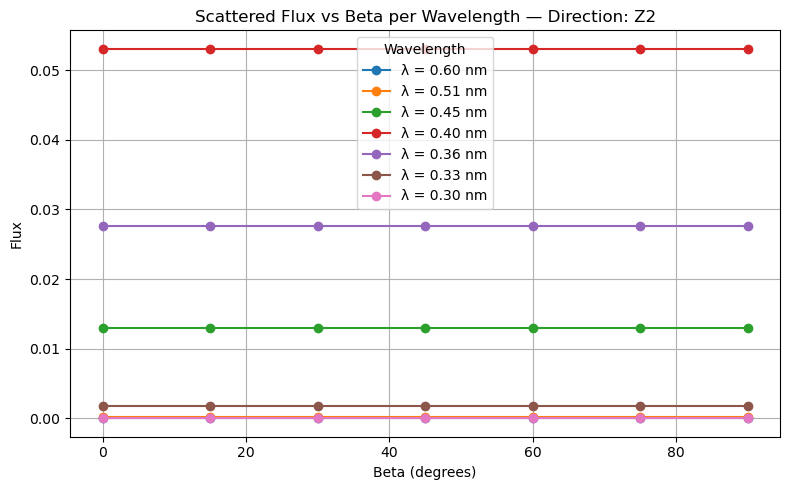

In [13]:
import matplotlib.pyplot as plt
import numpy as np

directions = sorted(df_scatt["direction"].unique())
frequencies = sorted(df_scatt["frequency"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for f in frequencies:
        sub = df_scatt[(df_scatt["direction"] == direction) & (np.isclose(df_scatt["frequency"], f, atol=1e-5))]
        plt.plot(sub["beta"], sub["flux"], marker='o', label=f"f = {f:.2f}")

    plt.title(f"Scattered Flux vs Beta — Direction: {direction}")
    plt.xlabel("Beta (degrees)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Frequency")
    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig(f"../plots/scattered_flux_beta_{direction}.png")

    # Plot flux vs beta per wavelength
    plt.figure(figsize=(8, 5))
    for f in frequencies:
        sub = df_scatt[(df_scatt["direction"] == direction) & (np.isclose(df_scatt["frequency"], f, atol=1e-5))]
        wavelengths = 1 / sub["frequency"]
        plt.plot(sub["beta"], sub["flux"], marker='o', label=f"λ = {wavelengths.iloc[0]:.2f} nm")
    plt.title(f"Scattered Flux vs Beta per Wavelength — Direction: {direction}")
    plt.xlabel("Beta (degrees)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Wavelength")
    plt.tight_layout()
    plt.savefig(f"../plots/scattered_flux_beta_wavelength_{direction}.png")
    plt.show()
    plt.close()



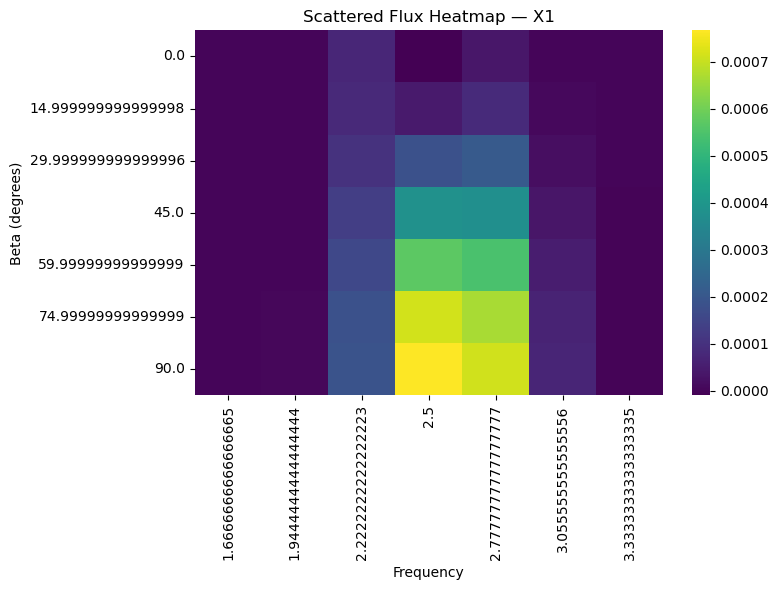

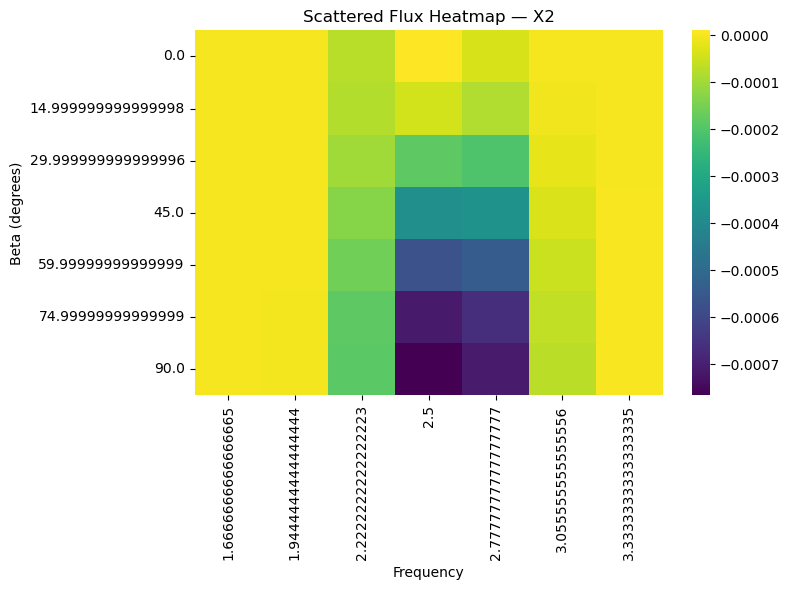

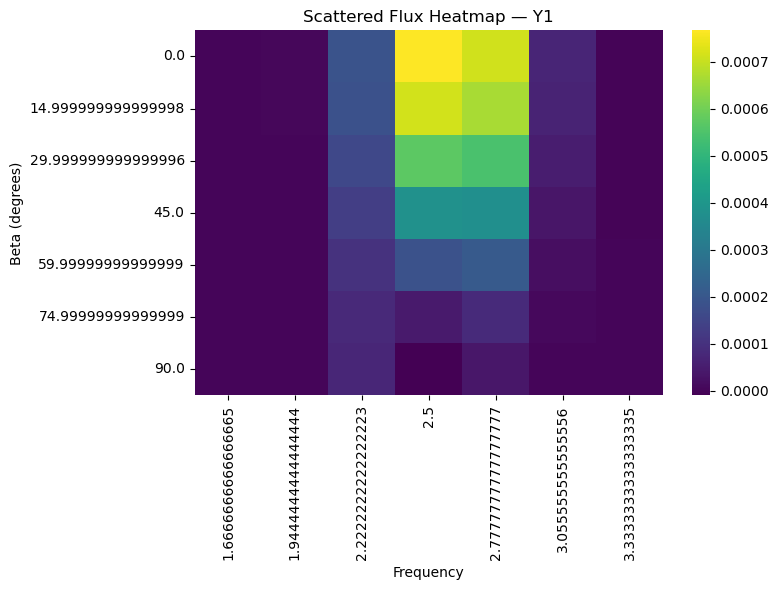

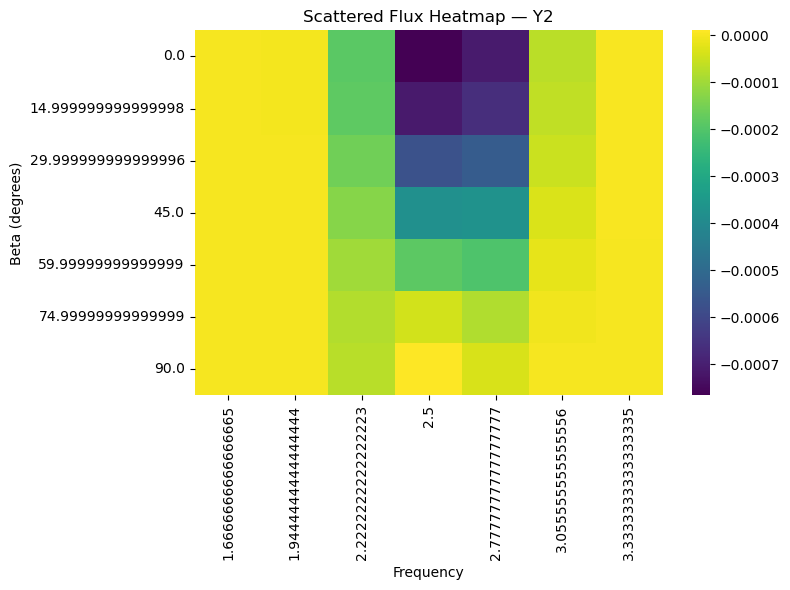

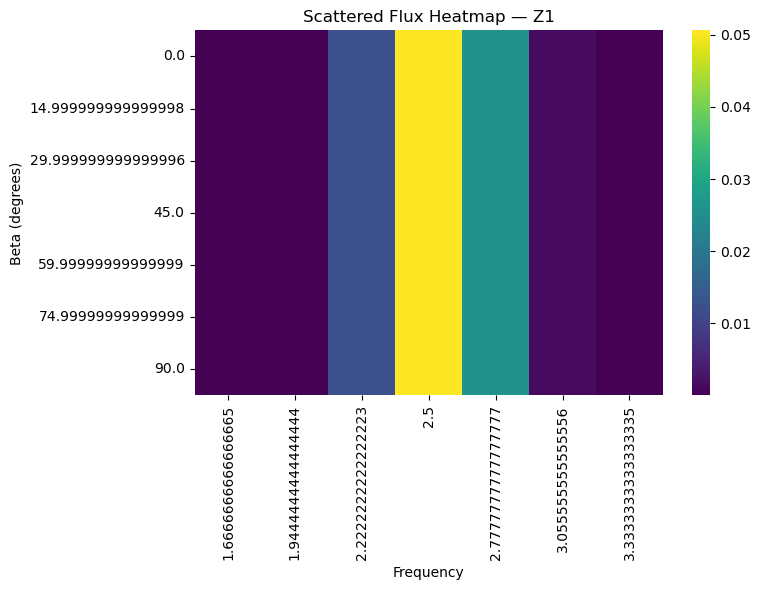

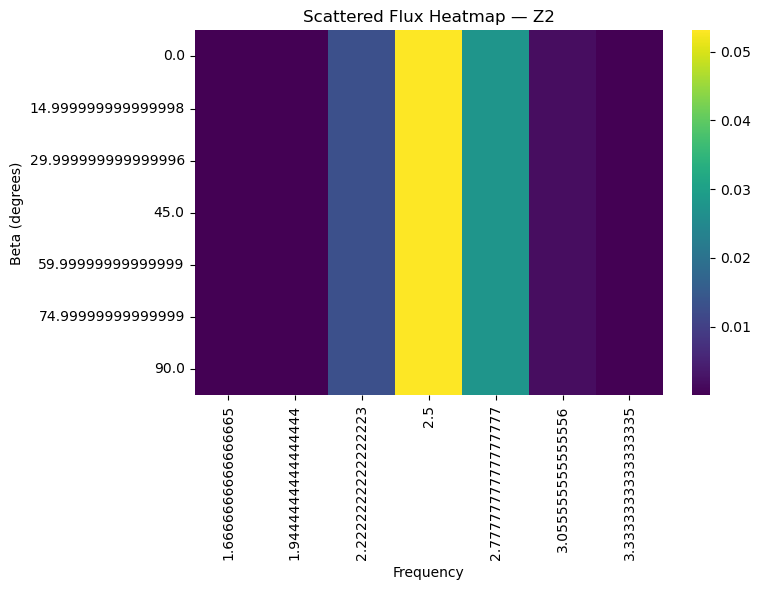

In [14]:
import seaborn as sns
for direction in directions:
    df_pivot = df_scatt[df_scatt["direction"] == direction].pivot(index="beta", columns="frequency", values="flux")
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_pivot, cmap="viridis")
    plt.title(f"Scattered Flux Heatmap — {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Beta (degrees)")
    plt.tight_layout()
    plt.show()


In [15]:
d = flux_1
#d = flux_1
print("Size of dict:", len(d))
d

Size of dict: 6


{'X1': array([ 3.49243249e-09,  1.09697621e-06,  7.23271731e-05, -1.02438959e-05,
         3.70208714e-05,  6.96823015e-07, -1.59454598e-07]),
 'X2': array([-3.49243249e-09, -1.09697621e-06, -7.23271731e-05,  1.02438959e-05,
        -3.70208714e-05, -6.96823015e-07,  1.59454598e-07]),
 'Y1': array([ 5.31727590e-09,  2.12948500e-06,  1.88800223e-04,  7.66586531e-04,
         7.11357977e-04,  6.97454546e-05, -2.97742152e-06]),
 'Y2': array([-5.31727590e-09, -2.12948500e-06, -1.88800223e-04, -7.66586531e-04,
        -7.11357977e-04, -6.97454546e-05,  2.97742152e-06]),
 'Z1': array([1.41700709e-07, 1.27106833e-04, 1.22570966e-02, 5.06061125e-02,
        2.53867685e-02, 1.54526182e-03, 2.38507211e-05]),
 'Z2': array([1.62531355e-07, 1.33726146e-04, 1.29850941e-02, 5.30869653e-02,
        2.76700423e-02, 1.76259846e-03, 6.51469573e-06])}

In [16]:
d = inc_flux_1
print("Size of dict:", len(d))
d




Size of dict: 6


{'X1': array([ 5.03100370e-22,  8.08006088e-21,  4.43102046e-20, -5.93368234e-19,
         1.75271168e-19, -1.00577782e-21,  3.50553038e-22]),
 'X2': array([ 1.32753600e-21, -2.31281459e-20, -2.24785740e-19,  2.65637087e-19,
         1.49838102e-20, -1.84252490e-21,  3.64890366e-22]),
 'Y1': array([ 1.36002329e-21,  1.39227068e-20,  7.60727973e-20, -6.14992783e-19,
        -3.37333976e-19,  1.03792014e-19,  1.69178817e-19]),
 'Y2': array([ 1.01364017e-21, -3.40518721e-20, -4.66837563e-20,  6.89434019e-19,
         1.59217441e-19,  4.24021616e-20, -1.17573547e-19]),
 'Z1': array([-6.05779281e-07, -2.05294494e-04, -7.81176078e-03, -3.31710046e-02,
        -1.63279429e-02, -1.00211687e-03, -1.78776736e-05]),
 'Z2': array([-5.99171148e-07, -2.05673449e-04, -7.81664920e-03, -3.31676178e-02,
        -1.63106452e-02, -1.00247314e-03, -2.02396797e-05])}